## Part 1: dask.delayed - parallelize any code

In [1]:
from dask.distributed import Client

client = Client(n_workers=4)

2025-10-16 18:25:40,146 - distributed.scheduler - WARNING - Worker failed to heartbeat for 927s; attempting restart: <WorkerState 'tcp://127.0.0.1:51032', name: 0, status: running, memory: 0, processing: 0>
2025-10-16 18:25:40,202 - distributed.scheduler - WARNING - Worker failed to heartbeat for 927s; attempting restart: <WorkerState 'tcp://127.0.0.1:51033', name: 1, status: running, memory: 0, processing: 0>
2025-10-16 18:25:40,207 - distributed.scheduler - WARNING - Worker failed to heartbeat for 927s; attempting restart: <WorkerState 'tcp://127.0.0.1:51034', name: 3, status: running, memory: 0, processing: 0>
2025-10-16 18:25:40,208 - distributed.scheduler - WARNING - Worker failed to heartbeat for 927s; attempting restart: <WorkerState 'tcp://127.0.0.1:51035', name: 2, status: running, memory: 0, processing: 0>
2025-10-16 18:25:40,611 - distributed.nanny - WARNING - Restarting worker
2025-10-16 18:25:40,615 - distributed.nanny - WARNING - Restarting worker
2025-10-16 18:25:40,623 

In [2]:
from time import sleep


def inc(x):
    sleep(1)
    return x + 1


def add(x, y):
    sleep(1)
    return x + y

In [3]:
%%time
# This takes three seconds to run because we call each
# function sequentially, one after the other

x = inc(1)
y = inc(2)
z = add(x, y)

CPU times: user 159 ms, sys: 64 ms, total: 223 ms
Wall time: 3.01 s


In [4]:
import dask


@dask.delayed
def inc(x):
    sleep(1)
    return x + 1


@dask.delayed
def add(x, y):
    sleep(1)
    return x + y

In [5]:
%%time
# This runs immediately, all it does is build a graph

x = inc(1)
y = inc(2)
z = add(x, y)

CPU times: user 1.09 ms, sys: 1.34 ms, total: 2.43 ms
Wall time: 2.04 ms


In [6]:
%%time
# This actually runs our computation using a local thread pool

z.compute()

CPU times: user 115 ms, sys: 48 ms, total: 163 ms
Wall time: 2.06 s


5

In [8]:
z

Delayed('add-d9a0add3-cdd6-494f-974b-0954186431f8')

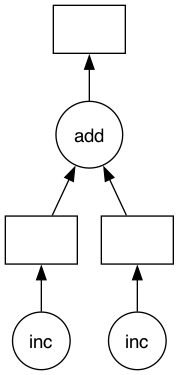

In [9]:
# Look at the task graph for `z`
z.visualize()

In [10]:
data = [1, 2, 3, 4, 5, 6, 7, 8]

In [11]:
%%time
# Sequential code


def inc(x):
    sleep(1)
    return x + 1


results = []
for x in data:
    y = inc(x)
    results.append(y)

total = sum(results)

CPU times: user 375 ms, sys: 150 ms, total: 525 ms
Wall time: 8.02 s


In [12]:
total

44

### Exercise 1

In [16]:
%%time
from dask import delayed
from time import sleep

results = []
for x in data:
    y = delayed(inc)(x)
    results.append(y)

total = delayed(sum)(results)

total.compute()

CPU times: user 121 ms, sys: 58.6 ms, total: 180 ms
Wall time: 1.14 s


44

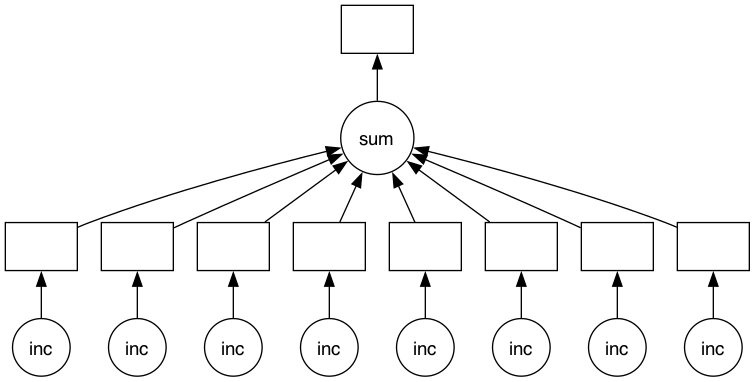

In [18]:
total.visualize()

In [19]:
@dask.delayed
def inc(x):
    sleep(1)
    return x + 1


results = []
for x in data:
    y = inc(x)
    results.append(y)

total = sum(results)
print("Before computing:", total)  # Let's see what type of thing total is
result = total.compute()
print("After computing :", result)  # After it's computed

Before computing: Delayed('add-e940efd337377942920ea68888b6703d')
After computing : 44


In [22]:
inc(1) + inc(2)

Delayed('add-019a593cd2ef0c965f841d62b6493758')

### Exercise: Parallelize a for-loop code with control flow

In [39]:
def double(x):
    sleep(1)
    return 2 * x


def is_even(x):
    return not x % 2


data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [40]:
%%time
# Sequential code

results = []
for x in data:
    if is_even(x):
        y = double(x)
    else:
        y = inc(x)
    results.append(y)

total = sum(results)
print(total)

Delayed('add-977d2544cb5d6afc9ea204494b5cd0fc')
CPU times: user 242 ms, sys: 140 ms, total: 383 ms
Wall time: 5.03 s


### Exercise 2

In [41]:
%%time


results = []
for x in data:
    if is_even(x):
        y = delayed(double)(x)
    else:
        y = delayed(inc)(x)
    results.append(y)

total = delayed(sum)(results)
print(total)

Delayed('sum-c80fdd6c-2778-4723-900e-bdc9fc2b757c')
CPU times: user 3.45 ms, sys: 1.37 ms, total: 4.82 ms
Wall time: 4.87 ms


In [42]:
%time total.compute()

CPU times: user 109 ms, sys: 58.7 ms, total: 168 ms
Wall time: 2.06 s


90

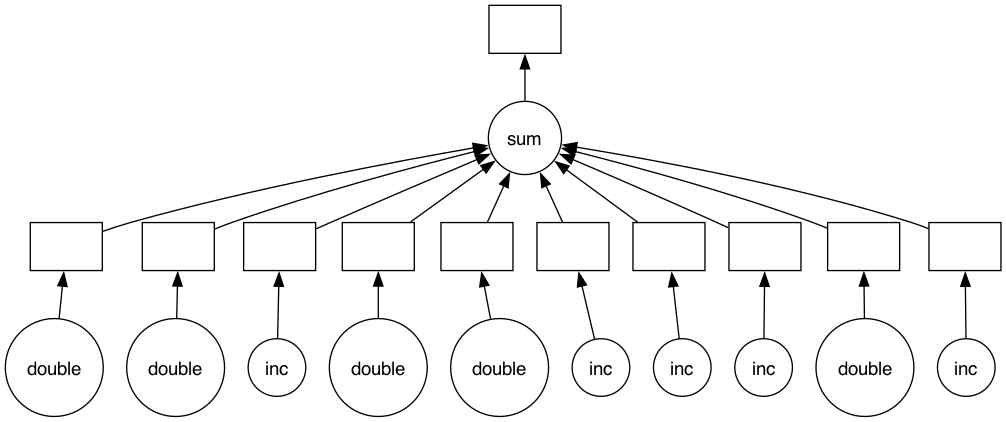

In [43]:
total.visualize()

In [44]:
@dask.delayed
def double(x):
    sleep(1)
    return 2 * x


results = []
for x in data:
    if is_even(x):  # even
        y = double(x)
    else:  # odd
        y = inc(x)
    results.append(y)

total = sum(results)

In [45]:
%time total.compute()

CPU times: user 128 ms, sys: 76.3 ms, total: 204 ms
Wall time: 2.07 s


90

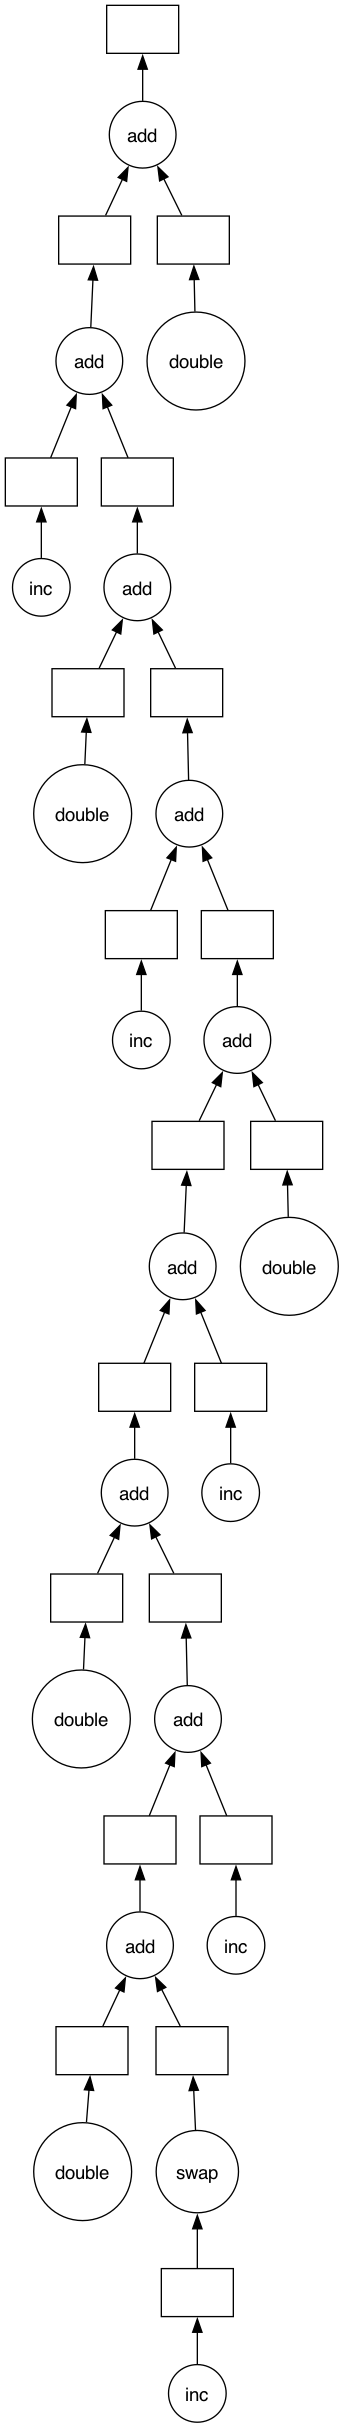

In [46]:
total.visualize()

### Exercise: Parallelize a Pandas Groupby Reduction

In [47]:
%run prep.py -d flights

In [48]:
import os

sorted(os.listdir(os.path.join("data", "nycflights")))

['1990.csv',
 '1991.csv',
 '1992.csv',
 '1993.csv',
 '1994.csv',
 '1995.csv',
 '1996.csv',
 '1997.csv',
 '1998.csv',
 '1999.csv']

In [49]:
import pandas as pd

df = pd.read_csv(os.path.join("data", "nycflights", "1990.csv"))
df.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
0,1990,1,1,1,1621.0,1540,1747.0,1701,US,33,...,NaN,46.0,41.0,EWR,PIT,319.0,NaN,NaN,0,0
1,1990,1,2,2,1547.0,1540,1700.0,1701,US,33,...,NaN,-1.0,7.0,EWR,PIT,319.0,NaN,NaN,0,0
2,1990,1,3,3,1546.0,1540,1710.0,1701,US,33,...,NaN,9.0,6.0,EWR,PIT,319.0,NaN,NaN,0,0
3,1990,1,4,4,1542.0,1540,1710.0,1701,US,33,...,NaN,9.0,2.0,EWR,PIT,319.0,NaN,NaN,0,0
4,1990,1,5,5,1549.0,1540,1706.0,1701,US,33,...,NaN,5.0,9.0,EWR,PIT,319.0,NaN,NaN,0,0


In [50]:
# What is the schema?
df.dtypes

Year                   int64
Month                  int64
DayofMonth             int64
DayOfWeek              int64
DepTime              float64
CRSDepTime             int64
ArrTime              float64
CRSArrTime             int64
UniqueCarrier         object
FlightNum              int64
TailNum              float64
ActualElapsedTime    float64
CRSElapsedTime         int64
AirTime              float64
ArrDelay             float64
DepDelay             float64
Origin                object
Dest                  object
Distance             float64
TaxiIn               float64
TaxiOut              float64
Cancelled              int64
Diverted               int64
dtype: object

In [51]:
# What originating airports are in the data?
df.Origin.unique()

array(['EWR', 'LGA', 'JFK'], dtype=object)

In [52]:
# Mean departure delay per-airport for one year
df.groupby("Origin").DepDelay.mean()

Origin
EWR     9.168411
JFK    11.857274
LGA     8.560045
Name: DepDelay, dtype: float64

In [57]:
from glob import glob

filenames = sorted(glob(os.path.join("data", "nycflights", "*.csv")))

In [58]:
%%time

sums = []
counts = []
for fn in filenames:
    # Read in file
    df = pd.read_csv(fn)

    # Groupby origin airport
    by_origin = df.groupby("Origin")

    # Sum of all departure delays by origin
    total = by_origin.DepDelay.sum()

    # Number of flights by origin
    count = by_origin.DepDelay.count()

    # Save the intermediates
    sums.append(total)
    counts.append(count)

# Combine intermediates to get total mean-delay-per-origin
total_delays = sum(sums)
n_flights = sum(counts)
mean = total_delays / n_flights

CPU times: user 2.03 s, sys: 528 ms, total: 2.56 s
Wall time: 2.72 s


In [59]:
mean

Origin
EWR    10.295469
JFK    10.351299
LGA     7.431142
Name: DepDelay, dtype: float64

### Exercise 3

In [61]:
from dask import delayed, compute

In [69]:
%%time

sums = []
counts = []
for fn in filenames:
    # Read in file
    df = delayed(pd.read_csv)(fn) #тут

    # Groupby origin airport
    by_origin = df.groupby("Origin")

    # Sum of all departure delays by origin
    total = by_origin.DepDelay.sum()

    # Number of flights by origin
    count = by_origin.DepDelay.count()

    # Save the intermediates
    sums.append(total)
    counts.append(count)

sums, counts = compute(sums, counts) # і тут

total_delays = sum(sums)
n_flights = sum(counts)
mean = total_delays / n_flights

CPU times: user 111 ms, sys: 80.1 ms, total: 191 ms
Wall time: 1.53 s


In [72]:
%%time

# This is just one possible solution, there are
# several ways to do this using `dask.delayed`


@dask.delayed
def read_file(filename):
    # Read in file
    return pd.read_csv(filename)


sums = []
counts = []
for fn in filenames:
    # Delayed read in file
    df = read_file(fn)

    # Groupby origin airport
    by_origin = df.groupby("Origin")

    # Sum of all departure delays by origin
    total = by_origin.DepDelay.sum()

    # Number of flights by origin
    count = by_origin.DepDelay.count()

    # Save the intermediates
    sums.append(total)
    counts.append(count)

# Combine intermediates to get total mean-delay-per-origin
total_delays = sum(sums)
n_flights = sum(counts)
mean, *_ = dask.compute(total_delays / n_flights)

CPU times: user 121 ms, sys: 74.8 ms, total: 195 ms
Wall time: 1.4 s


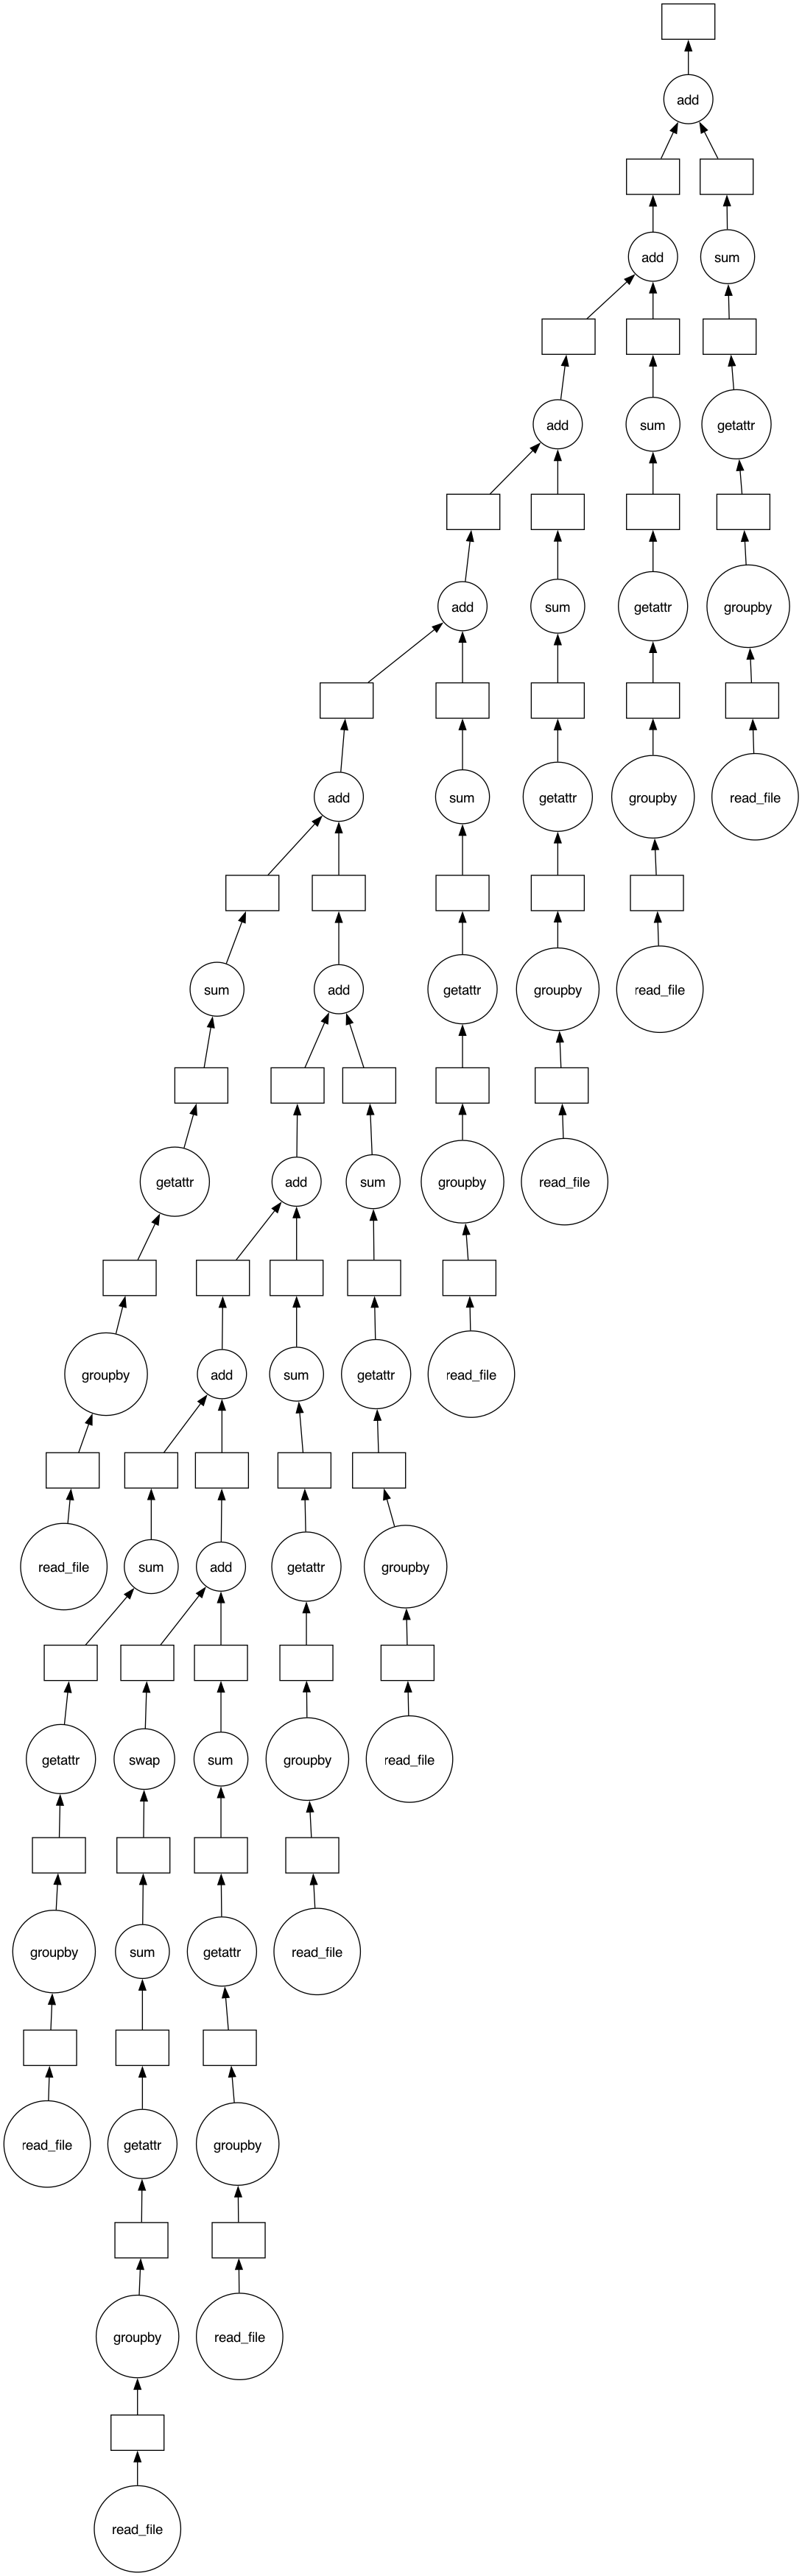

In [73]:
(sum(sums)).visualize()

In [74]:
# ensure the results still match
mean

Origin
EWR    10.295469
JFK    10.351299
LGA     7.431142
Name: DepDelay, dtype: float64

In [75]:
client.close()

## Part 2: Futures - non-blocking distributed calculations

In [76]:
from dask.distributed import Client

client = Client(n_workers=4)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 8.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:60701,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:60713,Total threads: 2
Dashboard: http://127.0.0.1:60719/status,Memory: 2.00 GiB
Nanny: tcp://127.0.0.1:60704,


In [77]:
from time import sleep


def inc(x):
    sleep(1)
    return x + 1


def double(x):
    sleep(2)
    return 2 * x


def add(x, y):
    sleep(1)
    return x + y

In [78]:
inc(1)

2

In [79]:
future = client.submit(inc, 1)  # returns immediately with pending future
future

<Future: pending, key: inc-dceea5011583364ce28b1388e39923b8>

In [80]:
future

<Future: finished, type: int, key: inc-dceea5011583364ce28b1388e39923b8>

In [81]:
future.result()

2

In [82]:
from dask.distributed import wait, progress
progress(future)

VBox()

In [83]:
wait(future)

DoneAndNotDoneFutures(done={<Future: finished, type: int, key: inc-dceea5011583364ce28b1388e39923b8>}, not_done=set())

In [86]:
import dask


@dask.delayed
def inc(x):
    sleep(1)
    return x + 1


@dask.delayed
def add(x, y):
    sleep(1)
    return x + y


x = inc(1)
y = inc(2)
z = add(x, y)

In [87]:
# notice the difference from z.compute()
# notice that this cell completes immediately
future = client.compute(z)
future

<Future: pending, key: add-30c60e47-d600-4609-b480-e248e10763db>

In [88]:
future.result()  # waits until result is ready

5

In [89]:
def inc(x):
    sleep(1)
    return x + 1


future_x = client.submit(inc, 1)
future_y = client.submit(inc, 2)
future_z = client.submit(sum, [future_x, future_y])
future_z

<Future: pending, key: sum-6556f1403e5c4a37f825d63ce968c3a7>

In [90]:
future_z

<Future: finished, type: int, key: sum-6556f1403e5c4a37f825d63ce968c3a7>

In [91]:
future_z.result()  # waits until result is ready

5

In [110]:
from random import random


def flaky_inc(i):
    if random() < 0.2:
        raise ValueError("You hit the error!")
    return i + 1

In [111]:
futures = client.map(flaky_inc, range(10))

In [112]:
for i, future in enumerate(futures):
    print(i, future.status)

0 finished
1 finished
2 finished
3 finished
4 finished
5 finished
6 finished
7 finished
8 finished
9 finished


In [113]:
futures[5].retry()

In [115]:
for i, future in enumerate(futures):
    print(i, future.status)

0 finished
1 finished
2 finished
3 finished
4 finished
5 finished
6 finished
7 finished
8 finished
9 finished


In [116]:
futures = client.map(flaky_inc, range(10), retries=5, pure=False)
future_z = client.submit(sum, futures)
future_z.result()

55